In [3]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 213 (delta 30), reused 36 (delta 13), pack-reused 141 (from 1)
Receiving objects: 100% (213/213), 279.75 MiB | 23.32 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Updating files: 100% (72/72), done.


In [2]:
import gdown

file_id = "1_XdzdW8UNG1TTS6QcX10uhoS6N11OBit"
destination = "mosi_data.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_XdzdW8UNG1TTS6QcX10uhoS6N11OBit
From (redirected): https://drive.google.com/uc?id=1_XdzdW8UNG1TTS6QcX10uhoS6N11OBit&confirm=t&uuid=99a46895-b834-4469-ab7c-4014e4c8858a
To: /content/meld_dataset.pkl
100%|██████████| 154M/154M [00:03<00:00, 48.2MB/s]


'meld_dataset.pkl'

In [5]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

In [6]:
from loader import get_dataloader
from unimodals.modules import Transformer, MLP, Sequential, Identity
from training.supervised import train, test
from fusions.modules import ConcatEarly
from utils import get_default_device, save_results

In [7]:
FILE_PATH = '/content/mosi_data.pkl'
train_data, valid_data, test_data = get_dataloader(FILE_PATH)

In [8]:
device = get_default_device()
print(device)

cuda


In [9]:
encoders = [Identity().to(device), Identity().to(device), Identity().to(device)]
head = Sequential(Transformer(325, 300).to(device), MLP(300, 128, 1)).to(device)
fusion = ConcatEarly().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [12]:
OUTPUT_MODEL_FILE_NAME = "MOSI_Late_Fusion_Transformer"

train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    100,
    task="regression",
    optimtype=torch.optim.AdamW,
    is_packed=True,
    early_stop=True,
    lr=1e-4,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/100]
Train Loss: 1.2712
Valid Loss: 1.2117
Saving Best

Epoch [2/100]
Train Loss: 0.9998
Valid Loss: 1.0826
Saving Best

Epoch [3/100]
Train Loss: 0.9378
Valid Loss: 1.0399
Saving Best

Epoch [4/100]
Train Loss: 0.8441
Valid Loss: 0.9801
Saving Best

Epoch [5/100]
Train Loss: 0.8148
Valid Loss: 0.9918

Epoch [6/100]
Train Loss: 0.7571
Valid Loss: 0.9526
Saving Best

Epoch [7/100]
Train Loss: 0.7052
Valid Loss: 0.9342
Saving Best

Epoch [8/100]
Train Loss: 0.6641
Valid Loss: 1.0818

Epoch [9/100]
Train Loss: 0.6291
Valid Loss: 0.9560

Epoch [10/100]
Train Loss: 0.5971
Valid Loss: 0.9087
Saving Best

Epoch [11/100]
Train Loss: 0.5404
Valid Loss: 0.9353

Epoch [12/100]
Train Loss: 0.5330
Valid Loss: 0.9404

Epoch [13/100]
Train Loss: 0.5061
Valid Loss: 0.9775

Epoch [14/100]
Train Loss: 0.4808
Valid Loss: 0.9670

Epoch [15/100]
Train Loss: 0.4614
Valid Loss: 0.9131

Epoch [16/100]
Train Loss: 0.4190
Valid Loss: 0.9118

Epoch [17/100]
Train Loss: 0.4006
Valid Loss: 0.9357

Epoch [

Text(0.5, 1.0, 'Loss vs. No. of epochs')

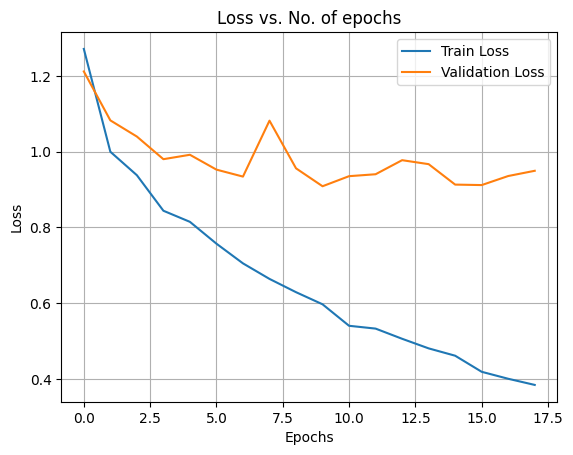

In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [15]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

In [16]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_data,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification",
)


<ipython-input-16-96d4c689c1d2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'/content/{FILE_NAME}.pt').to(device)


Recall: 76.3720% | Total Accuracy: 75.6560%
Inference Time: 516ms
Inference Params: 8103897
